In [1]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2
from torchinfo import summary
from matplotlib.colors import ListedColormap


In [2]:
batch_size = 256
learning_rate = 1e-4
num_epochs = 300
latent_dim = 3
mnist_class_anomaly = 4
kernels = 16
fuzzy_rules_count = 10

prefix = f"fuzzy_ad"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
binary_cmap = ListedColormap(['yellow', 'red'], N=2)
ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [3]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [4]:
class MNISTDatasetWithIdx(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self._dataset = dataset

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, idx):
        return (*self._dataset[idx], idx)

In [5]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data =MNISTDatasetWithIdx(datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
))

idx = (train_data._dataset.targets != mnist_class_anomaly)
train_data._dataset.targets = train_data._dataset.targets[idx]
train_data._dataset.data = train_data._dataset.data[idx]

dataset_utility = torch.zeros(len(train_data), fuzzy_rules_count)
dataset_utility = dataset_utility.to(device)
dataset_utility.shape

torch.Size([54158, 10])

загружаем тестовую выборку

In [6]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [7]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

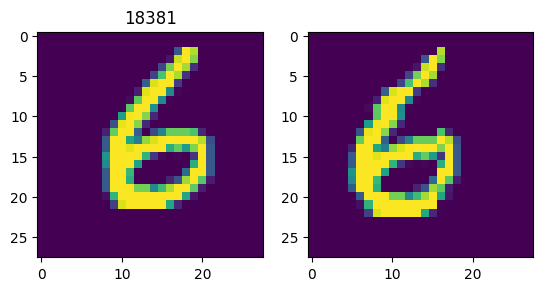

In [8]:
for data,_,idx in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.title(idx[0].item())
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, latent_dim, kernels):
        super(Encoder, self).__init__()
                
        self.latent = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=2, bias=False),
            nn.BatchNorm2d(8, affine=False),
            nn.MaxPool2d(2,2),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=2, bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.MaxPool2d(2,2),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=2, bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.MaxPool2d(2,2),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=2, bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(64, latent_dim, bias=False),
        )

    def forward(self, x):
        out = self.latent(x)

        return out
    

m = Encoder(latent_dim, kernels)
inp = torch.rand(batch_size, 1, 28, 28)
mu = m.forward(inp)
mu.shape
#summary(m, input_size=(batch_size, 1, 28, 28))

torch.Size([256, 3])

In [10]:
class FuzzyInferencer(nn.Module):
     def __init__(self, latent_dim, fuzzy_rules_count):
        super(FuzzyInferencer, self).__init__()
        #rscale = 10
        #initial_centroids = rscale * np.zeros((fuzzy_rules_count, latent_dim))
        #initial_scales = rscale * np.ones((fuzzy_rules_count, latent_dim))
        #radius = 1
        #center = 0.0
        #theta = np.linspace(0, 2*np.pi, fuzzy_rules_count)[:-1]
        #x = radius * np.cos(theta) + center
        #y = radius * np.sin(theta) + center
        #for i in range(fuzzy_rules_count):
        #    initial_centroids[i][0] = rscale * (center + np.random.randn())  #x[i]
        #    initial_centroids[i][1] = rscale * (center + np.random.randn()) #y[i]

        #initial_centroids[fuzzy_rules_count-1][0] = rscale * center
        #initial_centroids[fuzzy_rules_count-1][1] = rscale * center
        #initial_scales[fuzzy_rules_count-1][0] = 1
        #initial_scales[fuzzy_rules_count-1][1] = 1

        self.fuzzy = nn.Sequential(
            #FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=False),
            FuzzyLayer.from_dimensions(latent_dim, fuzzy_rules_count, trainable=True),
        )
        
     def forward(self, mu):
         return self.fuzzy(mu)
     
m = FuzzyInferencer(latent_dim, fuzzy_rules_count)
#inp = torch.rand(batch_size, latent_dim)
#mu = m.forward(inp)
#mu.shape
summary(m, input_size=(batch_size, latent_dim))

Layer (type:depth-idx)                   Output Shape              Param #
FuzzyInferencer                          [256, 10]                 --
├─Sequential: 1-1                        [256, 10]                 --
│    └─FuzzyLayer: 2-1                   [256, 10]                 131
Total params: 131
Trainable params: 90
Non-trainable params: 41
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [11]:
class FSVDD (nn.Module):
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(FSVDD, self).__init__()

        self.encoder = Encoder(latent_dim, kernels)
        self.fuzzy =  FuzzyInferencer(latent_dim, fuzzy_rules_count)
        

    def forward(self, x):
        mu = self.encoder(x)
        fz = self.fuzzy(mu)
        
        return mu, fz
    
m = FSVDD(latent_dim, fuzzy_rules_count, kernels)
#inp = torch.rand(10, fuzzy_rules_count)
#mu = m.forward(inp)
#mu[0].shape
summary(m, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FSVDD                                    [256, 3]                  --
├─Encoder: 1-1                           [256, 3]                  --
│    └─Sequential: 2-1                   [256, 3]                  --
│    │    └─Conv2d: 3-1                  [256, 8, 27, 27]          32
│    │    └─BatchNorm2d: 3-2             [256, 8, 27, 27]          --
│    │    └─MaxPool2d: 3-3               [256, 8, 13, 13]          --
│    │    └─SiLU: 3-4                    [256, 8, 13, 13]          --
│    │    └─Conv2d: 3-5                  [256, 16, 12, 12]         512
│    │    └─BatchNorm2d: 3-6             [256, 16, 12, 12]         --
│    │    └─MaxPool2d: 3-7               [256, 16, 6, 6]           --
│    │    └─SiLU: 3-8                    [256, 16, 6, 6]           --
│    │    └─Conv2d: 3-9                  [256, 32, 5, 5]           2,048
│    │    └─BatchNorm2d: 3-10            [256, 32, 5, 5]           --
│    │    └

## Обучение

In [12]:
model = FSVDD(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,066


FSVDD(
  (encoder): Encoder(
    (latent): Sequential(
      (0): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): SiLU()
      (4): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): SiLU()
      (8): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): SiLU()
      (12): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False,

In [13]:
def compute_ae_loss(x, recon_x):
    loss_recon = (1 - ssim(recon_x, x))
    return loss_recon.mean()
    

In [14]:

def compute_fz_loss(fz, act_thresh):
    fz_mx = fz.max(-1)
    mx_vals = fz_mx.values.reshape(-1, 1).repeat(1, fz.shape[1])
    target = torch.zeros_like(fz)
    target = torch.scatter(target, 1, fz_mx.indices.reshape(-1, 1), 1)
    target = torch.where(mx_vals > act_thresh, target, 1)
    target = target.detach()

    return (target - fz).square().mean()


In [15]:
def get_utilities_by_input_vs_centroid_similarity(model, data):
    inp_batch_size = data.shape[0]
    act_fz = model.fuzzy.fuzzy[0].get_centroids().detach()#torch.diag(torch.ones(fuzzy_rules_count)).to(device)
    raw_inferences = model.decoder_pass(act_fz)

    rimgs = data.repeat_interleave(fuzzy_rules_count, dim=0)
    rdfz = raw_inferences.repeat(inp_batch_size, 1, 1, 1)
    
    utilities = ssim(rdfz, rimgs).reshape(-1, fuzzy_rules_count)

    #utilities = torch.where(utilities > 0.8, 1e+1, utilities)

    return utilities
    
def compute_cfr_loss(fz, utilities):
    
    fz_util_tmp = (fz * utilities).sum(-1)
    fz_sum = fz.sum(-1)

    u_x = torch.where(fz_sum.abs() > 1e-20, fz_util_tmp/fz_sum, fz_util_tmp).reshape(-1, 1)

    regret = utilities - u_x
    zeros = torch.zeros_like(regret)
    regret = torch.maximum(regret, zeros)
    regret_sum = regret.sum(-1).reshape(-1, 1).repeat(1, fuzzy_rules_count)
    fz_upd = torch.where(regret_sum > 0, regret/regret_sum, 1/fuzzy_rules_count)
    
    fz_upd = fz_upd.detach()
    loss_fz = (fz_upd - fz).square().sum(-1).mean()
    
    return loss_fz, fz_upd

In [16]:
def compute_fzsum_loss(fz):
    return (1 - fz.sum(-1)).square().mean()

In [17]:
def fuzzy_term_volume_loss(layer, target_volume):
    ev = layer.get_transformation_matrix_eigenvals().real.min(-1).values
    ev = (target_volume - ev).square().mean()
    return ev

In [18]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [19]:
def get_arate(model, inp):
    mu, fz = model.forward(inp)
    #centroids = model.fuzzy.fuzzy[0].get_centroids().detach()
    #d = torch.cdist(mu, centroids).min(-1).values
    return fz.max(-1).values.cpu().numpy()# #(1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    #model.fuzzy.fuzzy.eval()
    #model.fuzzy.fuzzy[0].set_requires_grad_rot(False)
    #model.fuzzy.fuzzy[0].set_requires_grad_scales(False)
    for batch_idx, (data, _, item_idx) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  

        mu, fz = model(adata)  

        u = dataset_utility[item_idx]
        #loss_v =    fuzzy_term_volume_loss(model.fuzzy.fuzzy[0])
        loss_cfr, fz_upd = compute_cfr_loss(fz, u)
        
        loss_vol = fuzzy_term_volume_loss(model.fuzzy.fuzzy[0], 1)
        #loss_fz = (1 - fz.max(-1).values).clamp(max=0.8).square().mean() + fuzzy_term_volume_loss(model.fuzzy.fuzzy[0], 10)#+ (1 - fz.sum(-1)).square().mean() 
        #if(fz.sum(-1).mean() > 1):
        #    loss_fz += fuzzy_term_volume_loss(model.fuzzy.fuzzy[0])
            #centroids = model.fuzzy.fuzzy[0].get_centroids()
            #avg_d = torch.cdist(centroids, centroids).mean(-1).sum()
            #loss_fz += 1 / (avg_d + 1e-7)

        #loss_vol = fuzzy_term_volume_loss(model.fuzzy.fuzzy[0])
        #loss_fz_sum = compute_fzsum_loss(fz)

        #x_reconstruct = model.decoder_pass(mu)
        #loss_reconstruct = compute_ae_loss(data, x_reconstruct)
        
        ev_loss = keep_eigenvals_positive_loss(model.fuzzy.fuzzy[0])
        if ev_loss.item() > 0:
            print("EV trouble")
            ev_loss.backward(retain_graph=True)

        (loss_cfr + loss_vol).backward()
        #loss_cfr.backward()
        
        optimizer.step()  
        
        dataset_utility[item_idx] += fz.detach() #1e-2 * F.one_hot(fz.max(-1).indices, fuzzy_rules_count)

        if sched is not None:
            sched.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.12)    
        
    if writer is not None:
        writer.add_scalar('FSVDD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [21]:
def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 

    test_recon_loss = 0
    test_fz_vol = 0
    test_fz_sum = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.to(device)
            rates = get_arate(model, data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)

            mu, fz = model(data)  
            
            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())

            #loss_recon = compute_ae_loss(data, recon_x)
            
            fz_vol = fuzzy_term_volume_loss(model.fuzzy.fuzzy[0], 0)
            fz_sum = fz.sum(-1).mean()
            
            #test_recon_loss += loss_recon.item()
            test_fz_vol += fz_vol.item()
            test_fz_sum += fz_sum.item()
            
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)
   
    test_recon_loss /= len(dataloader)
    test_fz_vol /= len(dataloader)
    test_fz_sum /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, VOL: {test_fz_vol:.4f} SUM: {test_fz_sum:.2f} AUC: {roc_auc:.4f}')
    
    if writer is not None:
        writer.add_scalar('FSVDD/AUC', roc_auc, global_step=cur_step)
        #writer.add_scalar('FAE/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('FSVDD/Volume', test_fz_vol, global_step=cur_step)
        writer.add_scalar('FSVDD/Sum', test_fz_sum, global_step=cur_step)
        
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
        centroids_c = model.fuzzy.fuzzy[0].get_centroids().detach().cpu().numpy()
        
        ax[0].scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
        ax[0].scatter(centroids_c[:, 0],      centroids_c[:, 1], marker='1', c='green', s= 50)
        
        #ax[0].set_xlim(-1, 1)
        #ax[0].set_ylim(-1, 1)
        
        ax[1].scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
        ax[1].scatter(centroids_c[:, 0],      centroids_c[:, 2], marker='1', c='green', s= 50)
        
        #ax[1].set_xlim(-1, 1)
        #ax[1].set_ylim(-1, 1)
        
        #act_fz = model.fuzzy.fuzzy[0].get_centroids().detach()#torch.diag(torch.ones(fuzzy_rules_count)).to(device)#
        #samples = model.decoder_pass(act_fz)
        # img_idx = 0
        # fign, axn = plt.subplots(8, 1 + fuzzy_rules_count//8, figsize=(1 + fuzzy_rules_count//8, 8), squeeze=False)
        # for i in range(8):
        #     if img_idx >= fuzzy_rules_count:
        #         continue
        #     for j in range(fuzzy_rules_count//8):
        #         axn[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
        #         axn[i, j].axis('off')
        #         img_idx += 1

        writer.add_figure('FSVDD/Emedding', fig, global_step=cur_step)
        #writer.add_figure('FSVDD/Samples', fign, global_step=cur_step)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
#sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))
#sched = torch.optim.lr_scheduler.ConstantLR(optimizer, learning_rate)

In [23]:
prev_updates = 0

In [ ]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, None, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    scheduler.step()
    


[212] Reconstruction loss: 0.0000, VOL: 0.9582 SUM: 1.44 AUC: 0.6664
[424] Reconstruction loss: 0.0000, VOL: 0.9685 SUM: 1.41 AUC: 0.6552
[636] Reconstruction loss: 0.0000, VOL: 0.9635 SUM: 1.38 AUC: 0.5577
[848] Reconstruction loss: 0.0000, VOL: 0.9435 SUM: 1.40 AUC: 0.5537
[1060] Reconstruction loss: 0.0000, VOL: 0.9317 SUM: 1.42 AUC: 0.5318
[1272] Reconstruction loss: 0.0000, VOL: 0.9274 SUM: 1.39 AUC: 0.5232
[1484] Reconstruction loss: 0.0000, VOL: 0.9229 SUM: 1.37 AUC: 0.5262


In [ ]:
keep_eigenvals_positive_loss(model.fuzzy.fuzzy[0])

## Визуализируем результаты

In [ ]:
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import accuracy_score

# train_x = []
# test_x = []
# test_y = []
# with torch.no_grad():
#     for _, (data, _) in enumerate(tqdm(train_loader)):
#         data = data.to(device)
#         fz, _, _ = model.forward(data)
#         for f in fz:
#             train_x.append(f.cpu().numpy())

# with torch.no_grad():
#     for _, (data, target) in enumerate(tqdm(test_loader)):
#         data = data.to(device)
#         fz, _, _  = model.forward(data)
#         for f, trg in zip(fz, target):
#             test_x.append(f.cpu().numpy())
#             if trg == mnist_class_anomaly:
#                 test_y.append(-1)
#             else:
#                 test_y.append(1)
    
# clf = IsolationForest(random_state=0, n_estimators=1000).fit(train_x)
# y_pred =clf.predict(test_x)
# disp = ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred))
# disp.plot()
# accuracy_score(test_y, y_pred)

In [ ]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            _, fz, _ = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(9, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, fuzzy_rules_count + 1))

In [ ]:
test_stat_by_digit

In [ ]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')


In [ ]:
# fz = torch.zeros(64, fuzzy_rules_count).to(device)
# for i in range(64):
#     fz[i][5] = 1.0/(i+1)

# samples = model.decoder.decode_from_fz(fz)

# # Plot the generated images
# fig, ax = plt.subplots(8, 8, figsize=(8, 8))
# for i in range(8):
#     for j in range(8):
#         ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
#         ax[i, j].axis('off')

# # plt.show()
# plt.savefig('cvae_mnist.webp')

In [ ]:
ssim = piqa.SSIM(window_size = 9, n_channels=1, reduction='none').to(device)
def get_arate(inp):
    mu, fz_1, x_recon = model.forward(inp)
    #_, x_recon, fz_2 = model.forward(x_recon)
    
    return (1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy() #(1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy() #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

In [ ]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [ ]:
def show_plot():
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            embeding,_,_ = model.forward(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(target.cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [ ]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        _, fz, x_rec = model.forward(data)
        #_, x_rec_2, fz_2 = model.forward(x_rec)

        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        #plt.subplot(R, C, 1)
        #plt.imshow(fz[ind].detach().cpu().squeeze())
        #plt.bar(range(fuzzy_rules_count), fz[ind].detach().cpu().numpy(), color='g')
        #plt.bar(range(fuzzy_rules_count), fz_2[ind].detach().cpu().numpy(), color='r')
        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(x_rec[ind].detach().cpu().squeeze())
        #plt.subplot(R, C, 3)
        #plt.imshow(x_rec_2[ind].detach().cpu().squeeze())
        plt.subplot(R, C, 3)
        plt.imshow((x_rec[ind] - data[ind]).abs().detach().cpu().squeeze())
        #plt.subplot(R, C, 4)
        #plt.imshow(((data[ind]-x_rec[ind]).abs() - x_resd[ind]).abs().clamp(min=0.2).abs().detach().cpu().squeeze())
        break

In [ ]:
show_item_reconstructio(4)
show_item_reconstructio(3)